In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["OMP_NUM_THREADS"]="1"


%pip install bertopic
%pip install umap-learn
%pip install hdbscan
%pip install ipywidgets
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 5.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.6 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


## Load the embedding

## Apply Dimensionality Reduction

/Users/vesper/Desktop/LSE/Capstone Project/dissertation/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/Users/vesper/Desktop/LSE/Capstone Project/dissertation/.venv/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Reducing dimensions for expert embeddings...


/Users/vesper/Desktop/LSE/Capstone Project/dissertation/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Reducing dimensions for public embeddings...


/Users/vesper/Desktop/LSE/Capstone Project/dissertation/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Expert embeddings reduced shape: (1133, 5)
Public embeddings reduced shape: (20289, 5)
Saving reduced expert embeddings to the database...
Saving reduced public embeddings to the database...


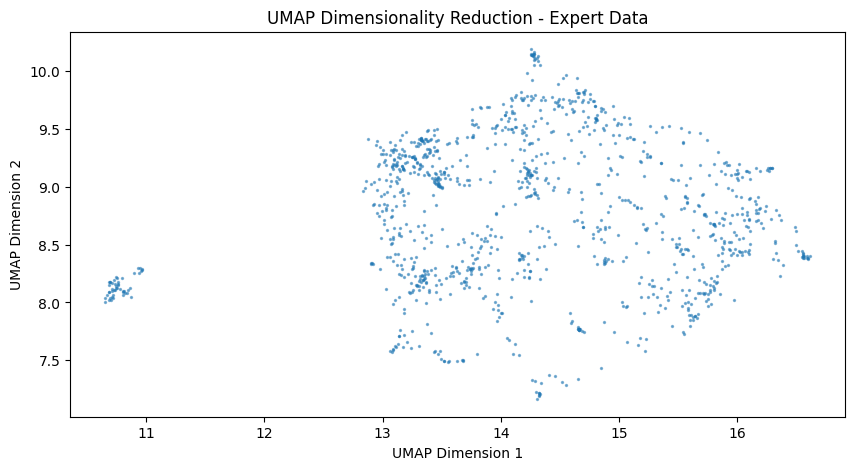

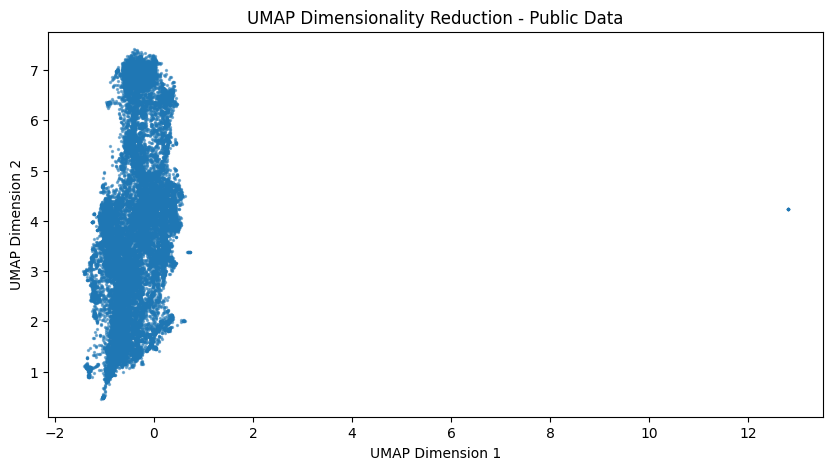

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from umap import UMAP
import matplotlib.pyplot as plt

# Establish connection to SQLite database
db_path = "/Users/vesper/Desktop/LSE/Capstone Project/dissertation/arctic_shift/filtered_data/relevant_data.db"
conn = sqlite3.connect(db_path)

# Load the cleaned expert and public datasets
expert_data = pd.read_sql_query("SELECT * FROM cleaned_expert_data", conn)
public_data = pd.read_sql_query("SELECT * FROM cleaned_public_data", conn)

# Load the embeddings from the database
expert_embeddings = pd.read_sql_query("SELECT * FROM expert_embeddings", conn)
public_embeddings = pd.read_sql_query("SELECT * FROM weighted_public_embeddings", conn)

# Drop the 'id' column to get the embeddings only
expert_embeddings = expert_embeddings.drop(columns=['id']).values
public_embeddings = public_embeddings.drop(columns=['id']).values

# Initialize UMAP model
umap_model_expert = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
umap_model_public = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Apply UMAP for dimensionality reduction
print("Reducing dimensions for expert embeddings...")
expert_reduced = umap_model_expert.fit_transform(expert_embeddings)
print("Reducing dimensions for public embeddings...")
public_reduced = umap_model_public.fit_transform(public_embeddings)

# Verify the reduced dimensions
print(f"Expert embeddings reduced shape: {expert_reduced.shape}")
print(f"Public embeddings reduced shape: {public_reduced.shape}")

# Save the reduced embeddings to new tables in the database
expert_reduced_df = pd.DataFrame(expert_reduced, columns=[f'dim_{i}' for i in range(expert_reduced.shape[1])])
public_reduced_df = pd.DataFrame(public_reduced, columns=[f'dim_{i}' for i in range(public_reduced.shape[1])])

# Add 'id' column to link back to the original data
expert_reduced_df['id'] = expert_data['id']
public_reduced_df['id'] = public_data['id']

print("Saving reduced expert embeddings to the database...")
expert_reduced_df.to_sql('reduced_expert_embeddings', conn, if_exists='replace', index=False)
print("Saving reduced public embeddings to the database...")
public_reduced_df.to_sql('reduced_public_embeddings', conn, if_exists='replace', index=False)

# Close the database connection
conn.close()

# Visualize the first two dimensions of the reduced expert embeddings
plt.figure(figsize=(10, 5))
plt.scatter(expert_reduced[:, 0], expert_reduced[:, 1], s=2, alpha=0.5)
plt.title('UMAP Dimensionality Reduction - Expert Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

# Visualize the first two dimensions of the reduced public embeddings
plt.figure(figsize=(10, 5))
plt.scatter(public_reduced[:, 0], public_reduced[:, 1], s=2, alpha=0.5)
plt.title('UMAP Dimensionality Reduction - Public Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()
